In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tardis import *
from scipy import sparse,ndimage
from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0


Using TensorFlow backend.


Running TARDIS 2.1...


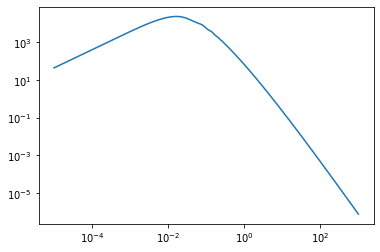

In [2]:
klin = np.loadtxt('Planck15_a1p00.txt').T[0]
plin = np.loadtxt('Planck15_a1p00.txt').T[1]
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [3]:
n=32
uni = universe(bs=n, nc=n,z_f=2,ipklin = ipklin )
uni.evolv()
flux_true = exp(-uni.final_tau_RSD)[0]

(32, 32, 32)
32768 65 32768
Total run time 1.9821925163269043


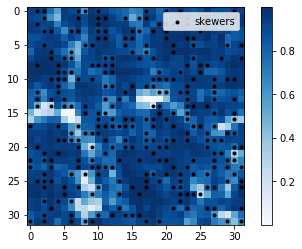

In [4]:
n_los = 300
mock_lya = lya_survey(uni,2,10,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

In [5]:
flux_true = exp(-uni.final_tau_RSD[0])
flux_obs = mock_lya.vals_observed
flux_contrast = flux_obs/flux_obs.mean()-1

In [6]:
d_los = n/(n_los)**0.5
l = n
map_n = n
num_pixels = len(mock_lya.skewers_fin.T[0])
d_los

1.8475208614068022

In [7]:
p = np.vstack([mock_lya.skewers_fin.T[0], mock_lya.skewers_fin.T[1],mock_lya.skewers_fin.T[2], 1/(mock_lya.inverse_covar[1])**0.5/flux_obs.mean(), flux_contrast]).T
p.tofile("pixel_data.bin")

In [8]:
# write config file
def write_run():
    cf = open("run.cfg", "w")
    cf.write("lx = %f\n" % l)
    cf.write("ly = %f\n" % l)
    cf.write("lz = %f\n" % l)
    cf.write("num_pixels = %i\n" % num_pixels)
    cf.write("map_nx = %i\n" % map_n)
    cf.write("map_ny = %i\n" % map_n)
    cf.write("map_nz = %i\n" % map_n)
    cf.write("corr_var_s = %f\n"%var(flux_obs))
    cf.write("corr_l_perp = %f\n" % d_los)
    cf.write("corr_l_para = %f\n" % d_los)
    cf.write("pcg_tol = 1.0e-5\n")
    cf.write("pcg_max_iter = 1000\n")
    cf.close()

In [9]:
write_run()

In [10]:
!/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/dachshund.exe run.cfg

Reading config file run.cfg.

Running dachshund with:
  pixels/map:
    lx ly lz = 32.000000 32.000000 32.000000
    npix = 9600
    map nx ny nz = 32 32 32, n = 32768
  signal:
    corr var_s = 0.383186
    l_perp = 1.847521    l_para = 1.847521
  WF x solve: 1
  PCG:
    max iter = 1000    step r = 50
    tol = 0.000010
  options:
    map covar = 0
  paths:
    pixel data = pixel_data.bin
    map = map.bin

Reading pixel data.
Preparing for x solve.
Starting solve.
[PCG] Solving 9600 x 9600 problem.
    Goal |r| < (tol) |b| = 1.053329e-03,  delta = 6.130770e+03
    iter 1, |r| 1.825543e+02, delta 1.633459e+04
    iter 2, |r| 1.171445e+02, delta 6.774850e+03
    iter 3, |r| 7.700058e+01, delta 2.828260e+03
    iter 4, |r| 5.171822e+01, delta 1.220831e+03
    iter 5, |r| 3.626607e+01, delta 6.087519e+02
    iter 6, |r| 2.506416e+01, delta 2.931470e+02
    iter 7, |r| 1.967381e+01, delta 1.808480e+02
    iter 8, |r| 1.525883e+01, delta 1.114220e+02
    iter 9, |r| 1.377604e+01, delta 8.

In [11]:
# get the reconstructed file
flux_contrast_wiener = np.fromfile('map.bin').reshape(n,n,n)
flux_wiener_recon = (flux_contrast_wiener+1)*flux_obs.mean()

In [12]:
opt_recon = reconstruct_opt(uni,mock_lya,anneal_steps=[2.5,1.5,1,0.7],k=[6,6,0.7,0.7],bound=False)
opt_recon.initmodel()
tau_opt_recon,flux_los_opt_recon = opt_recon.run_model()
flux_opt_recon = exp(-tau_opt_recon[0])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 258777.187500
  Number of iterations: 12
  Number of functions evaluations: 34
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 257529.046875
  Number of iterations: 22
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 255049.687500
  Number of iterations: 60
  Number of functions evaluations: 62
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 251351.578125
  Number of iterations: 30
  Number of functions evaluations: 31
Total run time 3.506086


In [16]:
flux_contrast_opt = flux_opt_recon/flux_opt_recon.mean()-1
flux_contrast_true = flux_true/flux_true.mean()-1

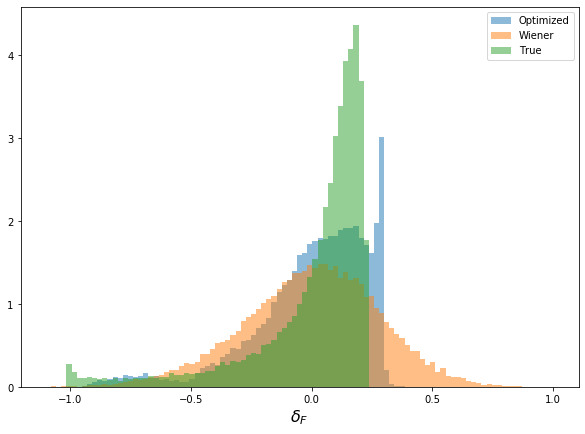

In [47]:
figure(figsize=(10,7))
bins = linspace(-1.1,1,100)
hist(flux_contrast_opt.flatten(),bins,alpha=0.5,label='Optimized',density=True)
hist(flux_contrast_wiener.flatten(),bins,alpha=0.5,label='Wiener',density=True)
hist(flux_contrast_true.flatten(),bins,alpha=0.5,label='True',density=True)
legend()
xlabel(r'$\delta_F$',fontsize=16)
show()

In [18]:
def so_avg(flux_contrast,coords,r):
    x,y,z = meshgrid(arange(n),arange(n),arange(n))
    mask = where((x-coords[0])**2+(y-coords[1])**2+(z-coords[2])**2<r**2)
    return sum(flux_contrast[x[mask],y[mask],z[mask]])/len(mask[0])

def void_finder(flux_contrast,soth=0.224,soavg=0.167):
    
    center_idx = where(flux_contrast>soth)
    print('Found %.d initial spheres'%len(center_idx[0]))

    center_coords = np.vstack(list(map(np.ravel, center_idx))).T
    rs = array([])
    for coords in center_coords:
        r = 1
        while True:
            if so_avg(flux_contrast,coords,r)>soavg:
                r+=1
            else:
                rs = np.append(rs,r)
                break
    for i,coords1 in enumerate(center_coords):
        for j,coords2 in enumerate(center_coords):
            if i<j:
                if sum((coords1-coords2)**2)**0.5<rs[i]+rs[j]:

                    if rs[i]>rs[j]:
                        rs[j]=-1
                    if rs[i]<=rs[j]:
                        rs[i]=-1
    idx = where(rs==-1)
    center_coords = delete(center_coords,idx,axis=0)
    rs = delete(rs,idx)
    
    return center_coords,rs

In [148]:
flux_contrast_true = flux_true/flux_true.mean()-1

In [19]:
center_coords_true,rs_true = void_finder(flux_contrast_true)

Found 355 initial spheres


Text(0.5, 0.92, 'True')

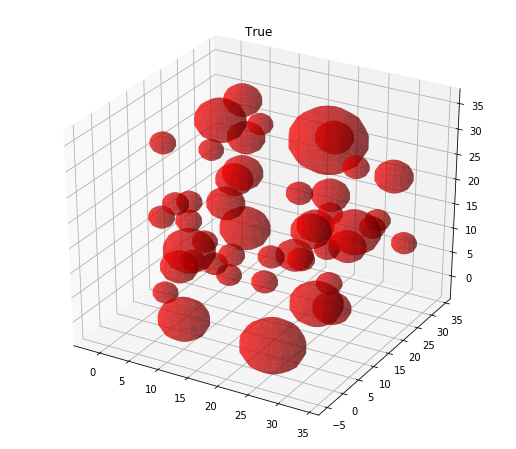

In [31]:
fig=figure(figsize=(9,8))
ax1 = fig.add_subplot(111,projection='3d')
# ax1.scatter(center_idx[0],center_idx[1],center_idx[2],alpha=0.3)
for i,coords in enumerate(center_coords_true):
    if rs_true[i]>1:
        u, v = np.mgrid[0:2*np.pi:16j, 0:np.pi:8j]
        x=rs_true[i]*np.cos(u)*np.sin(v)+coords[0]
        y=rs_true[i]*np.sin(u)*np.sin(v)+coords[1]
        z=rs_true[i]*np.cos(v)+coords[2]
        ax1.plot_surface(x, y, z, color="r",alpha=0.5)
ax1.set_title('True')

In [21]:
center_coords_opt,rs_opt = void_finder(flux_contrast_opt)

Found 5476 initial spheres


Text(0.5, 0.92, 'Optimized')

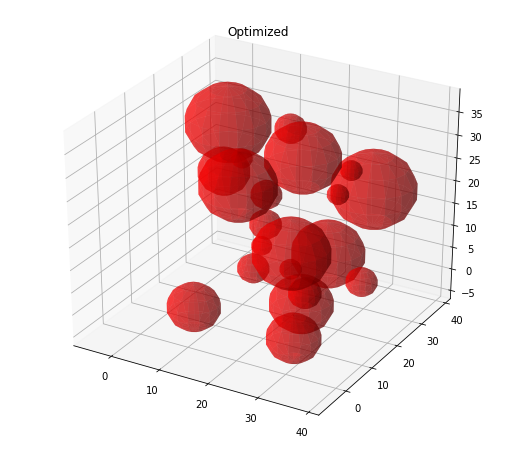

In [32]:
fig=figure(figsize=(9,8))
ax1 = fig.add_subplot(111,projection='3d')
# ax1.scatter(center_idx[0],center_idx[1],center_idx[2],alpha=0.3)
for i,coords in enumerate(center_coords_opt):
    if rs_opt[i]>1:
        u, v = np.mgrid[0:2*np.pi:16j, 0:np.pi:8j]
        x=rs_opt[i]*np.cos(u)*np.sin(v)+coords[0]
        y=rs_opt[i]*np.sin(u)*np.sin(v)+coords[1]
        z=rs_opt[i]*np.cos(v)+coords[2]
        ax1.plot_surface(x, y, z, color="r",alpha=0.5)
ax1.set_title('Optimized')

In [23]:
center_coords_wiener,rs_wiener = void_finder(flux_contrast_wiener)

Found 6842 initial spheres


Text(0.5, 0.92, 'Wiener')

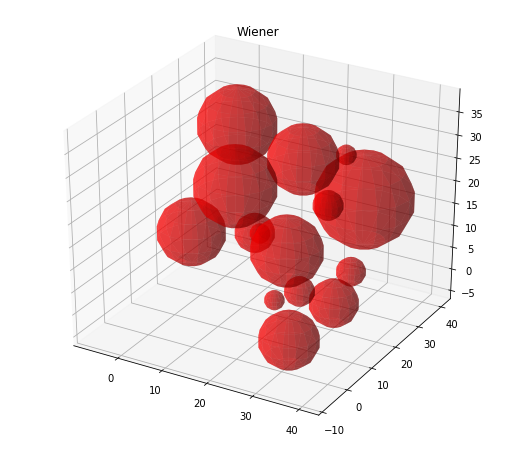

In [33]:
fig=figure(figsize=(9,8))
ax1 = fig.add_subplot(111,projection='3d')
# ax1.scatter(center_idx[0],center_idx[1],center_idx[2],alpha=0.3)
for i,coords in enumerate(center_coords_wiener):
    if rs_wiener[i]>1:
        u, v = np.mgrid[0:2*np.pi:16j, 0:np.pi:8j]
        x=rs_wiener[i]*np.cos(u)*np.sin(v)+coords[0]
        y=rs_wiener[i]*np.sin(u)*np.sin(v)+coords[1]
        z=rs_wiener[i]*np.cos(v)+coords[2]
        ax1.plot_surface(x, y, z, color="r",alpha=0.5)
ax1.set_title('Wiener')

Text(0.5, 0, 'Void radius(Mpc/h)')

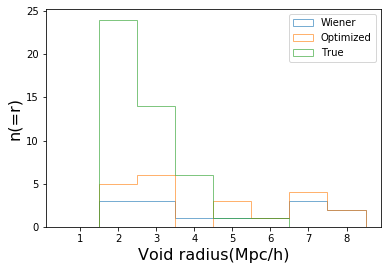

In [46]:
bins = arange(1,10)
hist_list = {'bins':bins,'align':'left','histtype':'step','density':False,'cumulative':False,'alpha':0.6}
hist(rs_wiener,label='Wiener',**hist_list)
hist(rs_opt,label='Optimized',**hist_list)
hist(rs_true,label='True',**hist_list)
legend()
ylabel(r'n(=r)',fontsize=16)
xlabel('Void radius(Mpc/h)',fontsize=16)

Text(0.5, 0, 'Void radius(Mpc/h)')

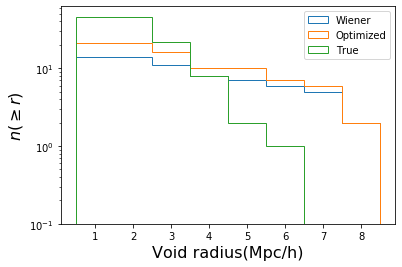

In [44]:
hist(rs_wiener,bins=bins,align='left',log=True,histtype='step',cumulative=-1,label='Wiener')
hist(rs_opt,bins=bins,align='left',log=True,histtype='step',cumulative=-1,label='Optimized')
hist(rs_true,bins=bins,align='left',log=True,histtype='step',cumulative=-1,label='True')
legend()
ylabel(r'$n(\geq r)$',fontsize=16)
xlabel('Void radius(Mpc/h)',fontsize=16)

In [27]:
sum(4/3*pi*rs_opt**3)/n**3

0.407655394380609

In [28]:
sum(4/3*pi*rs_wiener**3)/n**3

0.4554644622697115

In [29]:
sum(4/3*pi*rs_true**3)/n**3

0.16554209335932543